In [1]:
# Portions of today's lesson were adapted from materials developed by Jack Bennetto

# fredhutch.io -- Intermediate Python: Machine Learning
Fred Hutchinson Cancer Research Center

# Week 3 part 1 -- Logistic Regression in Classification
Last week, we looked closely at using linear regression to predict a target variable. In part 1 of this week, we'll examine why linear regression isn't such a good choice for classification and investigate logistic regression as a better alternative.

### By the end of part 1 of today's class, you should be able to:

 * Place logistic regression in the taxonomy of ML algorithms
 * Explain the key differences and similarities between logistic and linear regression.
 * Fit and interpret a logistic regression model in scikit-learn
 * Interpret the coefficients of logistic regression, using odds ratio

### Throughout we've scattered pairs of cells like the 2 immediately below. Use them to note your thoughts, answers to questions, and the code you're experimenting with.
(remember that you can change the type of a cell by going into command mode (cell highlighted in blue) and pressing `m` for markdown and `y` for code)

__________
Notes (markdown):

In [2]:
# Scratch area (code)

## Logistic regression as a model

Logistic regression is a **supervised-learning** **parametric** **classification** model.

A supervised-learning model is one in which we predict a target (or label or $y$) based on the values of the features (or $x$s). The alternative (an unsupervised model) tries to discover something about the data without predicting a specific value.

A parametric model is fit with a fixed number of parameters. Non-parametric models also have parameters but can by arbitrarily complex based on the data.

Supervised-learning models are (usually) either regressors or **classifiers**. With regressors the target is a number; given values for features it will predict a numeric value.

For a classifier (like logistic regression), the target is categorical. Mostly we'll discuss binary classifiers but consider multinomial classification as well. Our model will (or at least, should) predict the probability that the target would be in each possible class, rather than simply the "best" class. Some classifiers only predict a class rather than probabilities; these are called **hard classifiers**. In general, **soft classifiers** are more useful as they can be converted to hard classifiers if needed.

Logistic regression is generally the first thing you try when building a classifier and is actually used in some production environments.

Advantages:

 * Fast (for training and prediction)
 * Simple (few hyperparameters)
 * Interpretable
 * Provides good probabilities
 
Disadvantages

 * Requires feature engineering to capture non-linear relationships
 * Doesn't work for p > n

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
import itertools

## Why not linear regression?

Let's suppose we have some (fake) data, but that $y$ (the target) is always either 0 or 1.

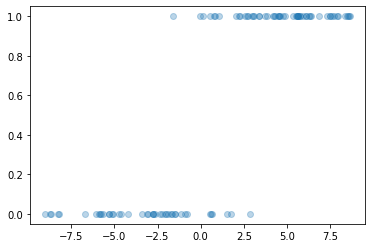

In [4]:
npts = 100

X = stats.uniform(-9, 18).rvs(npts).reshape(npts,1)
y = stats.bernoulli(scipy.special.expit(X[:,0])).rvs(npts)

fig, ax = plt.subplots()
ax.plot(X, y, 'o', alpha=0.3)

We focused previously on linear regression. Let's use that to predict $y$!

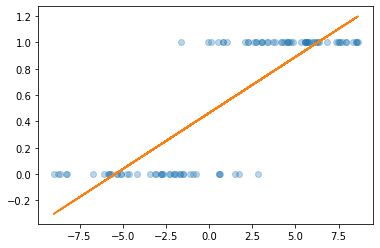

In [5]:
model = LinearRegression()
model.fit(X, y)
ax.plot(X, model.predict(X))
fig

Discussion: what's wrong with this?

__________
Notes (markdown):

In [6]:
# Scratch area (code)

## Comparison to linear regression

Recall that with linear regression we created a model like

$$\begin{align}
\hat{y} & = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... \beta_p X_p \\
  & = \mathbf{X} \beta
\end{align}$$

We tried to find the "best" line such that all the values of $\hat{y}$ were as close to the corresponding values of $y$ as possible. We defined this using a **loss function** that measured how bad of a job we did, and found the parameters for the line that would minimize that.

For a loss function we choose the sum of squares of the residuals:

$$\text{Loss function} = \sum_i{(\hat{y}_i - y_i) ^ 2}$$

Discussion: what loss function should we use for a classifier?

__________
Notes (markdown):

In [7]:
# Scratch area (code)

## Loss functions

There are a couple different options for loss functions. Sometimes we'll talk about a **score** rather than a loss; these only differ in the sign. For a loss function, a smaller value is a better fit; for a score, a larger value is a better fit.

For classifiers we almost always talk about the log loss but I'll mention the Brier score for comparison.

Assume we just have two classes, so $y_i \in \{0, 1\}$. Let $p_i$ be the probability the model predicts that the that $y_i$ is 1, i.e., $p_i = \mathbb{E}[\hat y_i]$.


The **log loss** is then defined as

$$- \sum_i y_i \ln{p_i} + (1-y_i) \ln{(1-p_i)}$$

**Question:** what's the log loss on a single point if the model predicts there's a 50% chance it's in one class and a 50% in the other?

The **brier loss** is given by

$$ \sum_i (y_i - p_i) ^ 2 $$

**Question:** what's the brier loss on a single point if the model predicts there's a 50% chance it's in one class and a 50% in the other?

Note that it's much more common to talk about **brier score** than brier loss; they are just the negatives of each other.

__________
Notes (markdown):

In [8]:
# Scratch area (code)

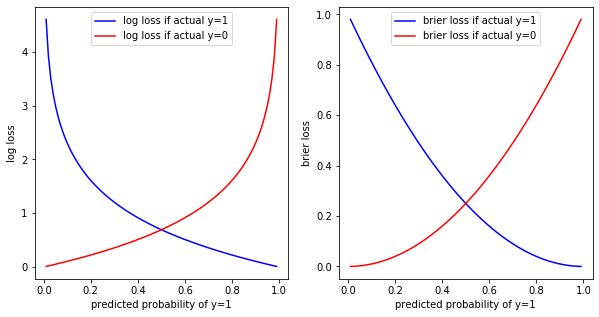

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
xpts = np.linspace(0.01, .99, 100)
axes[0].plot(xpts, -np.log(xpts), color='b', label="log loss if actual y=1")
axes[0].plot(xpts, -np.log(1-xpts), color='r', label="log loss if actual y=0")
axes[0].set_xlabel('predicted probability of y=1')
axes[0].set_ylabel('log loss')
axes[0].legend()

axes[1].plot(xpts, (1-xpts)**2, color='b', label="brier loss if actual y=1")
axes[1].plot(xpts, (xpts)**2, color='r', label="brier loss if actual y=0")
axes[1].set_xlabel('predicted probability of y=1')
axes[1].set_ylabel('brier loss')
axes[1].legend()

Now that we have a scoring rule, we need a function to fit. When doing linear regression we chose a straight line. Here we want a function that ranges from 0 to 1.

Here are a few choices.


(0, 1)

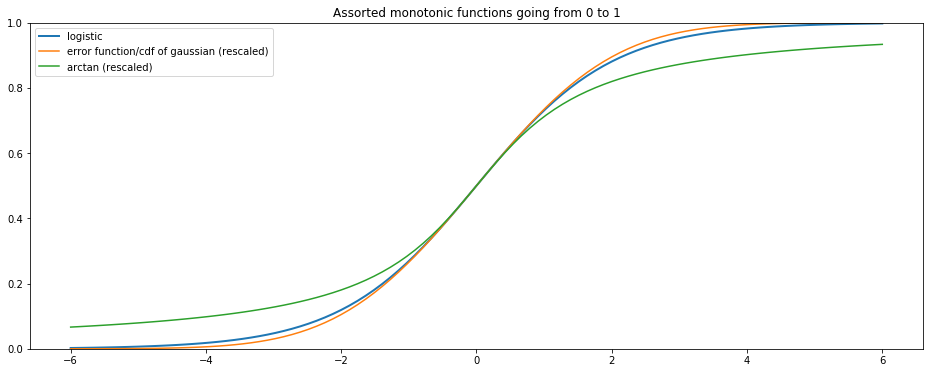

In [10]:
fig, ax = plt.subplots(figsize=(16,6))
xpts = np.linspace(-6, 6, 100)
ax.plot(xpts, 1/(1+np.exp(-xpts)), label='logistic', lw=2)
ax.plot(xpts, stats.norm(0,1).cdf((2*np.pi)**.5/4 * xpts), label='error function/cdf of gaussian (rescaled)')
ax.plot(xpts, np.arctan(np.pi/4*xpts)/np.pi + 0.5, label='arctan (rescaled)')
ax.legend()
ax.set_title("Assorted monotonic functions going from 0 to 1")
ax.set_ylim(0, 1)

We could choose any of these, but for various reasons we choose the logistic function, which is given by

$$f(x) = \frac{1}{1+e^{-x}}$$

If we substitute the $x$ with some parameters times the features, plus an intercept, and we find the values for those parameters that minimize log loss, we have logistic regression.

__________
Notes (markdown):

In [11]:
# Scratch area (code)

## Quick Statistical Aside - Probability vs Likelihood

Probability: Given a process for generating data, we can ask about the **probability** of getting a specific outcome.

example: Given a fair six-sided die (d6), what is the probability of rolling a 5 or 6 on the first try?

Likelihood: Given a specific outcome, we can ask about the **likelihood** that different processes generated the data.

example: Given a sequence of coin flips, is it more likely those flips were generated using a fair coin or a 60:40 head-weighted coin?

## MLE formulation


**Question:** what is MLE? Maximum Likelihood Estimator...

For logistic regression we'll change a couple things. First, we aren't going to use a line.

$$\begin{align}
Y & = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... \beta_p X_p + \epsilon \\
  & = \mathbf{X} \beta + \epsilon
\end{align}$$

where again

$$\epsilon \sim N(0, \sigma)$$


Alternatively, we could say
$$Y \sim N(\mathbf{X} \beta, \sigma)$$

From there, we want to find the values for $\beta$ that are the most likely to produce the data. The MLE estimate gives us ordinary least squares.

Discussion: how can we use MLE to the build a classification model?

__________
Notes (markdown):

In [12]:
# Scratch area (code)

### Constructing a model

To do any sort of prediction we need to create a model. Since we have two possible values of $y$ we assume the data is the result of a Bernoulli distribution, where $p$ is a function of $\mathbf{X}$.

$$Y \sim Bernoulli(f(\mathbf{X}))$$

We want our model to include some parameters so, as with linear regression, we'll have the function depend on the product of those parameters and $\mathbf{X}$.

$$Y \sim Bernoulli(f(\mathbf{X} \beta))$$

or


$$Y \sim Bernoulli(f(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... \beta_p X_p)$$

For $f$ we want a function with values from 0 to 1, what's called a sigmoid function. There are a number of different choices, but (for reasons we can get into later) the usual choice is the logistic function.

$$f(x) = \frac{1}{1+e^{-x}}$$

Question: now that we have a model, how should we find the best fit?

Again, we solve with maximum-likelihood estimation. Note that there isn't a close-form solution here; the computer has to solve numerically using some form of gradient descent (we can also talk about this later).

__________
Notes (markdown):

In [13]:
# Scratch area (code)

## Example (with fake data)

We'll generate fake data that matches the distribution exactly and try to recover the parameters.

In [14]:
def logistic(x):
    return 1/(1 + np.exp(-x))

In [15]:
npts = 100
beta0 = 0.0
beta1 = 0.5

X = stats.uniform(-9, 18).rvs(npts).reshape(npts,1)
# the expit function is the same as the logistic function
y = stats.bernoulli(logistic(beta0 + beta1*X[:,0])).rvs(npts)

We graph the data; the vertical line shows the actual decision boundary where the probability is 0.5.

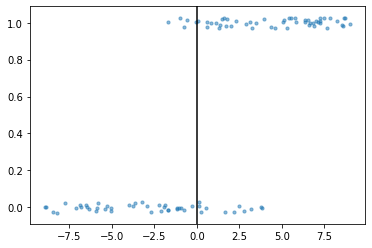

In [16]:
jitter = stats.uniform(-0.03,0.06).rvs(npts)
fig, ax = plt.subplots()
ax.scatter(X[:,0], y + jitter, s=10, alpha=0.5)
ax.axvline(-beta0/beta1, color='black')

In [17]:
# set C large to suppress regularization
model = LogisticRegression(C=1000)
model.fit(X, y)
beta0hat = model.intercept_[0]
beta1hat = model.coef_[0][0]
print("beta0 =    {0:8.3f} beta1 =    {1:8.3f}".format(beta0, beta1))
print("beta0hat = {0:8.3f} beta1hat = {1:8.3f}".format(beta0hat, beta1hat))

beta0 =       0.000 beta1 =       0.500
beta0hat =   -0.429 beta1hat =    0.628


Let's draw the curve we fitted on the data, along with the actual curve used to create the data.


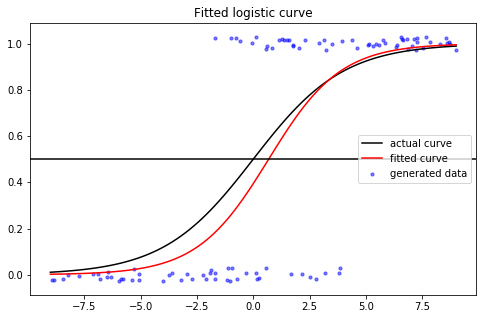

In [18]:
xpts = np.linspace(-9, 9, 100)
yhatpts = logistic(beta0hat + beta1hat * xpts)
ypts = logistic(beta0 + beta1 * xpts)

jitter = stats.uniform(-0.03,0.06).rvs(npts)

fig,ax = plt.subplots(figsize=(8,5))
ax.scatter(X[:,0], y + jitter, s=10, alpha=0.5, color='blue', label="generated data")
ax.plot(xpts, ypts, 'k', label='actual curve')
ax.plot(xpts, yhatpts, 'r', label='fitted curve')
ax.axhline(0.5, color='black')
#ax.axvline(-beta0/beta1, color='black', label='actual boundary')
ax.set_title("Fitted logistic curve")
ax.legend(loc='center right')

__________
Notes (markdown):

In [19]:
# Scratch area (code)

## Log odds ratio

In gambling people often talk about **odds**. If the local sportsball is favored to win 3-to-1 (or 3:1), that means that the ratio of the probability of winning is three times as great as the probability of losing, so they have a 75% chance of winning. Odd of 1:1 are even; they are as likely to win as the are to lose.

(In gambling people always give the larger number first, so a 25% chance of winning is said to be 3:1 against. We won't do that, but will instead say the odds are 1:3.)

The **odds ratio** is the ratio of the of the probability of the positive to the negative case, i.e., 

$$OR = \frac{P(y=1)}{1-P(y=1)}$$

Question: what's the odds ratio if $P(y=1) = 0.5$?

Question: what if the probability of the positive class is 80%?

Question: what if it's 20%?

Question: what if it's 10%?

The **log odds ratio** is just the log (base e) of that.

Question: what is the log odds ratio if $P(y=1) = 0.5$

Question: what if it's 80%?

Question: what if it's 20%?

__________
Notes (markdown):

In [20]:
# Scratch area (code)

So what does that have to do with logistic regression? The logistic function takes the log odds of something and returns the probability. Let's explore this a bit more.

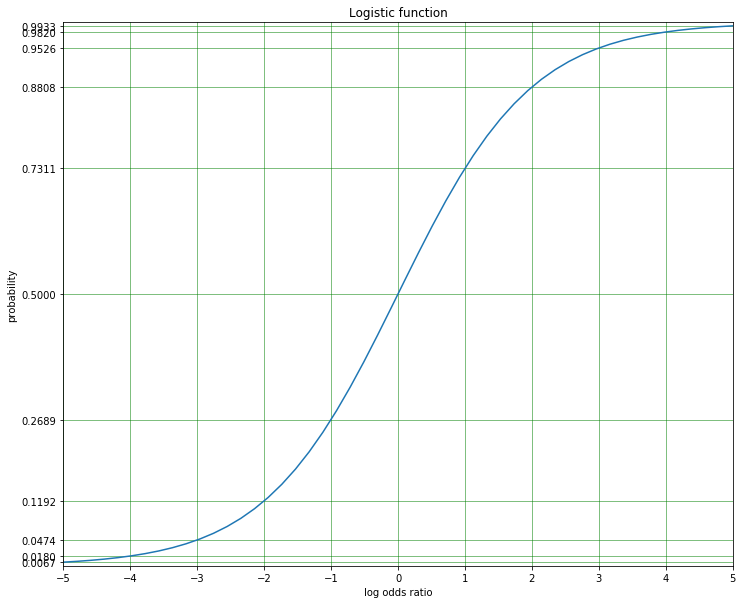

In [21]:
xpts = np.linspace(-5, 5)
fig, ax = plt.subplots(figsize=(12,10))

ax.plot(xpts, logistic(xpts))

xticks = np.arange(-5, 6, 1)
ax.set_xticks(xticks)
ax.set_yticks(logistic(xticks))

ax.grid(color='g', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlim(-5, 5)
ax.set_ylim(-0, 1)
ax.set_title("Logistic function")
ax.set_xlabel("log odds ratio")
ax.set_ylabel("probability")
plt.show()

In [22]:
x = np.arange(-10, 11)
df = pd.DataFrame(['{:.3f}%'.format(a*100) for a in logistic(x)], index=x, columns=['probability'])
df.index.name = 'log odds ratio'
df

,probability
log odds ratio,
-10,0.005%
-9,0.012%
-8,0.034%
-7,0.091%
-6,0.247%
-5,0.669%
-4,1.799%
-3,4.743%
-2,11.920%


__________
Notes (markdown):

In [23]:
# Scratch area (code)

### The math

If you're doing logistic regression, then the probability of something being in the positive class is
$$P(y=1) = \frac{1}{1+e^{-\mathbf{X}\beta}}$$

so

$$\begin{align}
OR &= \frac{P(y=1)}{1-P(y=1)} \\
   &= \frac{\frac{1}{1+e^{-\mathbf{X}\beta}}}{1-\frac{1}{1+e^{-\mathbf{X}\beta}}} \\
   &= \frac{\frac{1}{1+e^{-\mathbf{X}\beta}}}{\frac{1+e^{-\mathbf{X}\beta}}{1+e^{-\mathbf{X}\beta}}-\frac{1}{1+e^{-\mathbf{X}\beta}}} \\
   &= \frac{1}{e^{-\mathbf{X}\beta}} \\
   &= e^{\mathbf{X}\beta}
\end{align}
$$
so
$$log(OR) = \mathbf{X}\beta$$

So if you increase $X_i$ by 1, you increase $log(OR)$ by $\beta_i$.

__________
Notes (markdown):

In [24]:
# Scratch area (code)

## Decision boundary

There are a number of different classification models that are worth talking about. A good model will do more than just predict to which class something belongs; it will predict the probability that it is in that class.

At some point, though, we need to make a decision. To do that we choose a **threshold** at which we will place something in one class or the other. The **decision boundary** is the surface in feature space at which the probability is equal to the threshold.

Suppose we have two features, $X_1$ and $X_2$, and we set the threshold equal to 0.5. That corresponds to a log odds ratio of 0 so the decision boundary is at

$$\beta_0 + \beta_1 X_1 + \beta_2 X_2 = 0$$

so

$$ X_2 = \frac{-\beta_0}{\beta_2} + \frac{-\beta_1}{\beta_2}X_1 $$

More broadly, for threshold $\theta$, the decision boundary is the region for which

$$\theta = \frac{1}{1+e^{-\mathbf{X} \beta}}$$

$$\theta + \theta e^{-\mathbf{X} \beta} = 1$$

$$e^{-\mathbf{X} \beta} = \frac{1 - \theta}{\theta}$$

$$\mathbf{X} \beta = \ln{(\frac{\theta}{1 - \theta})}$$

Which again is the log odds ratio, so

$$\beta_0 + \beta_1 X_1 + \beta_2 X_2 = \ln{(\frac{\theta}{1 - \theta})}$$

so

$$X_2 = \frac{\ln{(\frac{\theta}{1 - \theta})} - \beta_0}{\beta_2} +  \frac{-\beta_1}{\beta_2}X_1 $$

__________
Notes (markdown):

In [25]:
# Scratch area (code)

In [26]:
def generate_classes(nptses, mus, sds):
    """
    Generate normally distributed points in multiple classes
    Parameters
    ----------
    nptses : array_like (1-d)
        sequence of numbers, the count of points in each class
    mus : array_like (2-d)
        sequence of vectors, the means of the multivariate distributions for each class
    mus : array_like (3-d)
        sequence of 2-d symmetric tensors, the standard deviation of the multivariate
        distributions for each class
        
    Returns
    -------
    X : array (2-d)
        features of generated points
    y : array (2-d)
        integer labels of points, starting at 0
    """

    X = np.zeros((0,2))
    y = np.zeros((0,))
    
    for i, npts, mu, sd in zip(itertools.count(), nptses, mus, sds):
        X = np.concatenate([X, stats.multivariate_normal(mu, sd).rvs(npts)])
        y = np.concatenate([y, np.ones(npts)*i])
    return X, y
        

In [27]:
X, y = generate_classes((1000,1000),
                       ((2.0, 2.5),
                        (6.0, 0.0)),
                       (((2.0, 0),
                         (0, 3.0)),
                        ((2.5, 0),
                         (0, 3.0)))
                       )

In [28]:
def decision_boundary_x2(x, b0, b1, b2, threshold):
    return (np.log((1 - threshold)/threshold) - b0 - x*b1 )/b2

def plot_decision_boundary(X, y, model, ax=None):
    '''plot 2-d array of points, with decision boundaries'''
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(X[:,0], X[:,1], color=np.where(y, 'g', 'b'), alpha=0.5, s=3)
    ax.plot(*X[y==0].mean(axis=0).reshape(-1,1), color='b', marker='+', mew=4, ms=20)
    ax.plot(*X[y==1].mean(axis=0).reshape(-1,1), color='g', marker='+', mew=4, ms=20)
    ax.axis('equal')

    xmin, xmax = X[:,0].min(), X[:,0].max()
    xrng = np.array([2*xmin-xmax, 2*xmax-xmin])

    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    beta0 = model.intercept_
    beta1, beta2 = model.coef_[0]
    print (beta0, beta1, beta2)
    
    for threshold, ls in zip(1/(1+np.exp(-np.arange(-3,4))), [':', '-.', '--', '-', '--', '-.', ':']):
        ax.plot(xrng,
                decision_boundary_x2(xrng, beta0, beta1, beta2, threshold),
                color='r',
                ls=ls,
                label="{:.2f}%".format(threshold*100))
    ax.legend(title='threshold')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

[-5.57994993] 1.6674404361440622 -0.8009664125688299


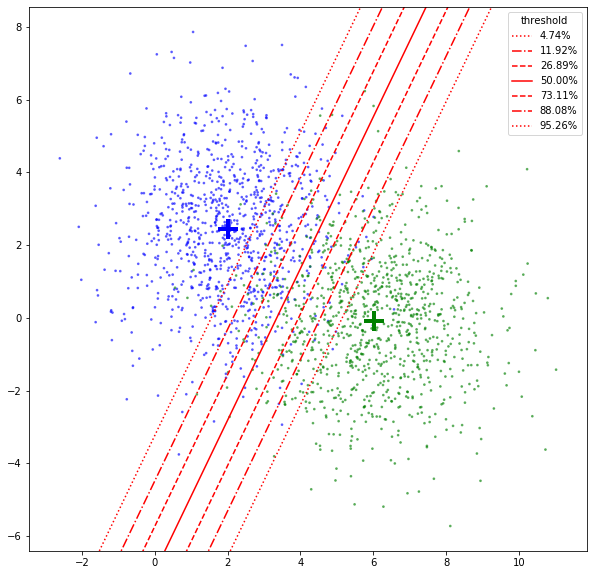

In [29]:
X, y = generate_classes((1000,1000),
                       ((2.0, 2.5),
                        (6.0, 0.0)),
                       (((2.0, 0),
                         (0, 3.0)),
                        ((2.5, 0),
                         (0, 3.0)))
                       )
model = LogisticRegression(C=1000, intercept_scaling=100)
model.fit(X, y)

plot_decision_boundary(X, y, model)

__________
Notes (markdown):

In [30]:
# Scratch area (code)

## Confusion matrix

A [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) gives the count of instances based on the actual and predicted values of the target. For a binary classifier it looks like

|      &nbsp;            |Predicted positive|Predicted negative |
|--------------------|------------------|---------------|
| **Actual positive**| true positive    | false negative|
| **Actual negative**| false positive   | true negative |


*True* and *false* refer to whether you are correct.

*Positive* and *negative* refer to the **predicted** result.

A *type-I error* is a false positive (which I remember because that phrase is more common than false negative).

Accuracy $= \frac{TP+TN}{TP+TN+FP+FN}$

Sensitivity = Recall = TPR $= \frac{TP}{TP+FN}$

FPR $= \frac{FP}{TN+FP}$

Specificity $= \frac{TN}{TN+FP}$

Precision = PPV $= \frac{TP}{TP+FP}$

NPV $= \frac{TN}{TN+FN}$

![confusion matrix](../img/Confusion_Matrix.png)

#### F-score

$F_\beta$ evaluates a test assuming that recall is $\beta$ times as important as precision; it's a weighted harmonic mean of the two.

$$F_\beta = (1+\beta^2) \frac{\text{precision} \cdot \text{recall}}{\beta^2\text{precision} + \text{recall} } $$

$$F_1 = 2 \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall} }  = \frac{1}{\frac{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}{2}}$$

__________
Notes (markdown):

In [31]:
# Scratch area (code)

## ROC Curves

Any decent classification model will provide the probabilities that a data point is in one class or another. To visualize the overall goodness of a model we use a Receiver Operator Characteristic curve, which shows the TPR (a.k.a Sensitivity) and FPR (a.k.a. 1-Specificity) for various thresholds.

An alternative is the Precision-recall curve, which is more appropriate when you're more interested in the positive class.

Models can be compared by the Area Under the Curve (AUC) of either graph.

Note: We're using a the `predict_proba` method below in `sklearn`.

In [32]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()
    
def plot_precision_recall(ax, df):
    ax.plot(df.tpr,df.precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(left=0,right=1)
    ax.set_ylim(bottom=0,top=1)

In [33]:
X, y = generate_classes((1000,1000),
                       ((2.0, 2.5),
                        (6.0, 0.0)),
                       (((2.0, 0),
                         (0, 3.0)),
                        ((2.5, 0),
                         (0, 3.0)))
                       )
model = LogisticRegression(C=1000)
model.fit(X, y)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

[-6.3277027] 1.8815952337117516 -0.8809879461422789


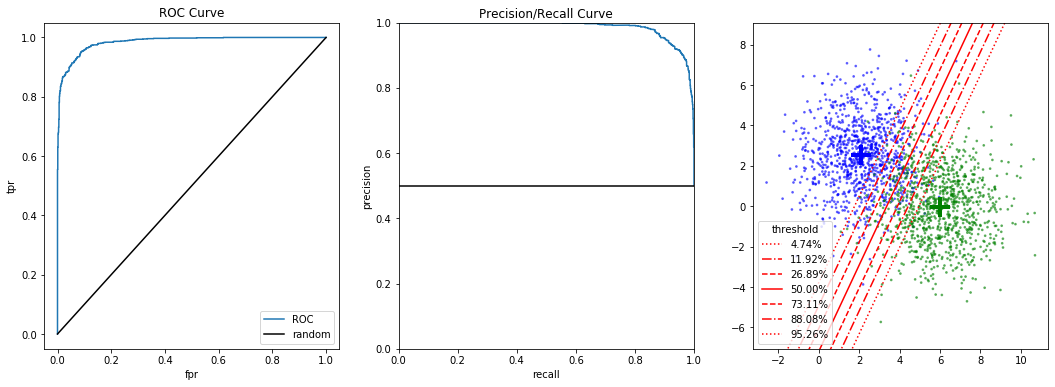

In [34]:
fig, (ax0, ax1, ax3) = plt.subplots(1,3, figsize=(18,6))
df = calculate_threshold_values(model.predict_proba(X)[:,1], y)
plot_roc(ax0, df)
plot_precision_recall(ax1, df)
plot_decision_boundary(X, y, model, ax3)

The "random" black line is a model that guesses the class randomly, parameterized by the probability of guessing one class or another.

There's a nifty probabilistic interpretation of the AUC; you can find a discussion of it by Matt Drury in http://madrury.github.io/jekyll/update/statistics/2017/06/21/auc-proof.html


__________
Notes (markdown):

In [35]:
# Scratch area (code)

# Week 3 part 2 -- Bagging & Random Forests in Regression & Classification
Last week, we used random forests as a contrast to our linear regression model. In part 2 of this week, we'll examine how decision trees, bagging, and random forests relate to one another and how we can build and interpret random forests in the context of regression and classification.

### By the end of part 2 of today's class, you should be able to:

 * Explain the relationship and difference between bagging and a random forest.
 * Explain why bagging/random forests are more accurate than a single decision tree.
 * Explain & construct a random forest (classification or regression).
 * Get feature importances from a random forest (if there is enough time).
 * Explain how OOB error is calculated and what it estimates (if there is enough time).

## Agenda

 * Discuss ensemble methods
 * Review bias/variance tradeoff
 * Review decision trees
 * Discuss bagging (bootstrap aggregation)
 * Discuss random forests
 * Discuss out-of-bag error (if there is enough time)
 * Discuss feature importance (if there is enough time)

In [36]:
# Redundant imports left in to allow the two halves of today's lesson to be independent.
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import comb

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.datasets import load_breast_cancer, load_iris

## What is an Ensemble Method?

In general, an **ensemble** method combines many weak models to form a strong model. We train multiple models on the data, such that each is different. They could be trained on different subsets of the data, or trained in different ways, or even be completely different types of models.

Once we've done that, we need to combine the models to form a single model.

**Class discussion:** how would get a single prediction from an ensemble of **regression** models?

**Class discussion:** how would get a single prediction from an ensemble of **classification** models?



## Ensembles: Intuition

Suppose we have 5 *independent* hard binary classifiers (they only give 0 or 1). If they are each 70% accurate, what's the accuracy of an ensemble of them?

**Question:** what does independent mean?

In [37]:
def find_ensemble_accuracy(n, p):
    '''Given n independent classifiers each of p accuracy,
    return the ensemble accuracy'''
    ensemble_accuracy = 0
    for k in range((n + 1) // 2, n+1):
        ensemble_accuracy += comb(n, k) * p**k * (1-p)**(n-k)
    return ensemble_accuracy

In [38]:
find_ensemble_accuracy(5, 0.7)

0.8369199999999999

Text(0.5, 1.0, 'Accuracy of an Ensemble of Independent Classifiers')

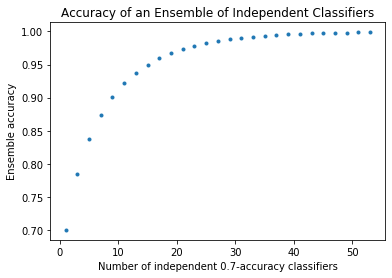

In [39]:
ns = np.arange(1, 55, 2)
vfea = np.vectorize(find_ensemble_accuracy, excluded=['p'])
ensemble_accuracies = vfea(ns, p=0.7)

fig, ax = plt.subplots()
ax.plot(ns, ensemble_accuracies, '.')
ax.set_ylabel("Ensemble accuracy")
ax.set_xlabel("Number of independent 0.7-accuracy classifiers")
ax.set_title("Accuracy of an Ensemble of Independent Classifiers")

$$ \binom{5}{5} 0.7^5 + \binom{5}{4} 0.7^4 0.3 + \binom{5}{3} 0.7^3 0.3^2 \approx 0.83 $$

With 55 such classifiers we can achieve 99.9% accuracy.


**Question:** what's the limitation?

## How to Make Them Independent?

If the learners are all the same, ensembles don't help.

Train each learner on different subset of data.

**Question:** Why is this better than a single good model?

__________
Notes (markdown):

In [40]:
# Scratch area (code)

## Bias and Variance

**Question:** what is bias?

**Question:** what is variance?

**Question:** what is the bias of an unpruned decision tree?

__________
Notes (markdown):

In [41]:
# Scratch area (code)

## Review: Classification Trees

A **classification tree** is a decision tree to predicts whether a data point is in one class or another. Each branch node is a decision, choosing left or right based on the value of a certain feature. Each leaf node gives the probability that a data point is in one class or another.

Let's look at a small tennis dataset.

In [42]:
# Read in our data
tennis_df = pd.read_csv('../data/tennis.txt', delim_whitespace=True)
tennis_df.rename(columns={'playtennis': 'played'}, inplace=True)
#tennis_df['played'] = tennis_df['played'].apply(lambda x: 1 if x == 'yes' else 0)
tennis_df

,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


You need graphviz to generate the chart below. Note that this chart is neat, but not critical for the lesson.

On MacOS or a Linux distro, it is probably easiest to run `conda install python-graphviz` from your terminal. This may also work for Windows users.

You can also `pip install graphviz`, although you might have to manually change your `PATH` to include the graphviz executables.

In [43]:
from graphviz import Digraph
dot = Digraph(comment='A simple classification tree')

dot.node('O', 'outlook?', shape='diamond')
dot.node('1', "no", shape='rectangle')
dot.node('H', 'humidity?', shape='diamond')
dot.node('O2', 'outlook?', shape='diamond')
dot.node('W', 'wind?', shape='diamond')
dot.node('3', 'yes', shape='rectangle')
dot.node('T', 'temperature?', shape='diamond')
dot.node('4', 'yes', shape='rectangle')
dot.node('5', "no", shape='rectangle')
dot.node('2', "no", shape='rectangle')
dot.node('W2', 'wind?', shape='diamond')
dot.node('6', "no", shape='rectangle')
dot.node('7', 'yes', shape='rectangle')

dot.edge('O', '1', 'overcast')
dot.edge('O', 'H', 'not overcast')
dot.edge('H', 'O2', 'high')
dot.edge('H', 'W', 'normal')
dot.edge('W', '3', 'False')
dot.edge('W', 'T', 'True')
dot.edge('T', '4', 'mild')
dot.edge('T', '5', 'cool')
dot.edge('O2', '2', 'sunny')
dot.edge('O2', 'W2', 'rainy')
dot.edge('W2', '7', 'False')
dot.edge('W2', '6', 'True')
dot

ModuleNotFoundError: No module named 'graphviz'

A classification tree is built by

* Iteratively divide the nodes such that (entropy/gini impurity) is minimized
* Various stopping conditions like a depth limit
* Prune trees by merging nodes

__________
Notes (markdown):

In [44]:
# Scratch area (code)

## Review: Regression Trees

A **regression tree** predicts a number rather than the probability that something is in one class or another. Prediction works the same as with classification trees, but the leaf nodes give a number rather than probabilities of a class.

To train a regression tree, we

* Iteratively divide the nodes such that *total squared error* is minimized,

$$\sum_{i \in L} (y_i - m_L)^2 + \sum_{i\in R} (y_i - m_R)^2$$

* Use various stopping conditions like a depth limit, minimum leaf size, and
* Prune trees by merging nodes

## Regression Trees: Example

 $x_1$ |   $x_2$ |  $y$
-------|---------|--------
 1     |    1    |   1
 0     |    0    |   2
 1     |    0    |   3
 0     |    1    |   4

 Prior to the split we guess the mean, 2.5, for everything, giving total squared error:
 
 $$ E = (1-2.5)^2 + (2-2.5)^2 + (3-2.5)^2 + (4-2.5)^2  = 5$$
 After we split on $x_1$ we guess 2 for rows 1 & 3 and 3 for rows 2 & 4:
 
 $$ E = (1-2)^2 + (3-2)^2 + (2-3)^2 + (4-3)^2 = 4 $$

## Decision Tree Summary

What are the pros and cons?

Pros
 * No feature scaling needed
 * Model nonlinear relationships
 * Can do both classification and regression
 * Robust
 * Highly interpretable

Cons
 * Can be expensive to train
 * Often poor predictors because of high variance


__________
Notes (markdown):

In [45]:
# Scratch area (code)

## Quick Look: Bootstrapping

What is a bootstrap sample?

What are bootstrap samples are good for?

Let's get the median of some data.

In [46]:
data = stats.uniform(0,10).rvs(100)
np.median(data)

5.459813735823449

What's the confidence interval of this estimate?

In [47]:
def bootstrap_confidence_interval(data, function, alpha=0.05, n_bootstraps=1000):
    '''return a the confidence interval for a function of data using bootstrapping'''
    medians = []
    for _ in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, len(data))
        medians.append(function(bootstrap_sample))
    return (np.percentile(medians, 100*(alpha/2.)),
            np.percentile(medians, 100*(1-alpha/2.)))

In [48]:
alpha = .05
ci = bootstrap_confidence_interval(data, np.median, alpha)

print("The {}% confidence interval is from {} to {}".format(1-alpha, *ci))

The 0.95% confidence interval is from 3.967935052216067 to 6.9256285473199775


Our procedure was
  * Take 1000 bootstrap samples.
  * Take the median of each sample.
  * The 95% confidence inverval for the median is between the 25th and 975th largest samples.
  
To confirm this worked, let's do it a bunch of times.

In [49]:
hits = []
for _ in range(100):
    data = stats.uniform(0,10).rvs(100)
    ci = bootstrap_confidence_interval(data, np.median)
    hits.append(ci[0] < 5.0 and ci[1] > 5.0)
print(np.mean(hits))

0.97


That doesn't work every time, but it will if we do it a lot longer.

__________
Notes (markdown):

In [50]:
# Scratch area (code)

## Bootstrapped aggregation

 * We are thinking about the population of all possible decision tree models on our data.
 * If I take $n$ *iid* (independent and identically distributed) samples from this distribution and average them the variance goes down by $\sqrt n$
 * There is some correlation between models because they are all trained on bootstrap samples from the same draw.

## An Experiment

You're each going to be a decision tree on some data based on a bootstrap sample, and then we'll all ensemble the results.

In [51]:
data = load_iris()

# Split into test/train, using the same random state for everyone
X_train, X_test, y_train, y_test = train_test_split(data.data,
                                                    data.target,
                                                    random_state=462)

In [52]:
clf = DecisionTreeClassifier()
# each of you has a different bootstrap sample
bootstrap_sample = np.random.choice(range(len(X_train)),
                                    len(X_train),
                                    replace=True)
clf.fit(X_train[bootstrap_sample], y_train[bootstrap_sample])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [53]:
print("Accuracy = {:.3f}".format(np.mean(clf.predict(X_test) == y_test)))

Accuracy = 0.868


In [54]:
print("My prediction: {}".format(clf.predict(X_test)[0:20]))
print("Actual result: {}".format(y_test[0:20]))

My prediction: [0 2 0 1 1 1 2 2 0 2 2 0 2 2 2 1 1 2 1 0]
Actual result: [0 2 0 1 2 1 2 2 0 2 2 0 1 2 2 2 1 2 1 0]


What is your prediction?

This concept, creating each model from a bootstrap sample and aggregating the results, is called **bagging**. It could really be used with any sort of model, but is generally done with decision trees.

**Question:** why?

__________
Notes (markdown):

In [55]:
# Scratch area (code)

### Bootstrapping on Regression Trees

Let's do another example. Consider some points.

In [56]:
n_data = 5000
x = stats.uniform(0, 10).rvs(n_data)
y = np.cos(x) + stats.norm(0, 0.5).rvs(n_data)

Text(0, 0.5, 'y')

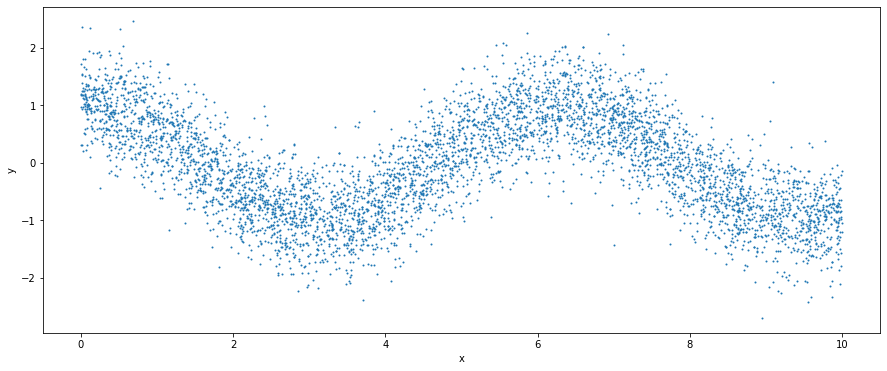

In [57]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(x, y, '.', ms=2)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [58]:
max_depth = 5
model = DecisionTreeRegressor(max_depth=max_depth)
model.fit(x.reshape(-1, 1), y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

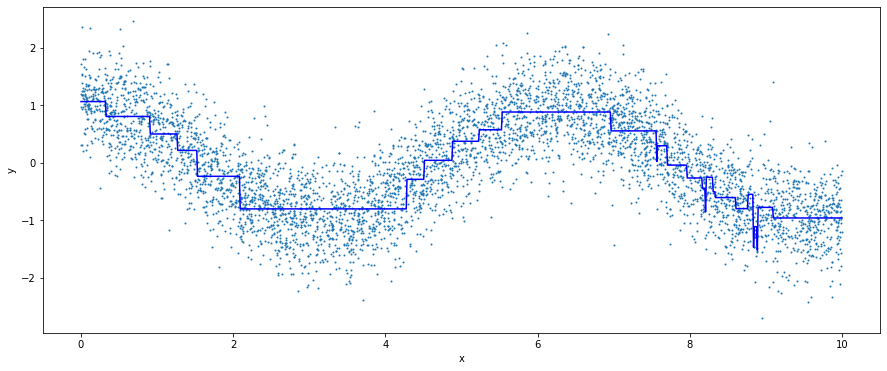

In [59]:
n_pts = 1000
xpts = np.linspace(0, 10, n_pts)
p1 = ax.plot(xpts, model.predict(xpts.reshape(-1, 1)), 'b')
fig

That's what one decision tree looks like; each discontinuity is a node split. What if we create a bunch of bootstrap samples and build an ensemble of trees from them?

In [60]:
n_bootstraps = 5000
yptses = np.zeros((n_bootstraps, n_pts))
for i in range(n_bootstraps):
    bootstrap = np.random.choice(np.arange(n_data), n_data, True)
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(x[bootstrap].reshape(-1, 1), y[bootstrap])
    yptses[i] = model.predict(xpts.reshape(-1, 1))

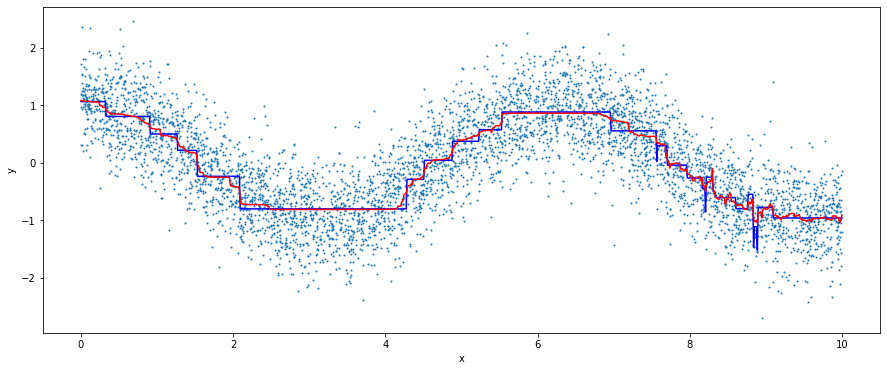

In [61]:
ax.plot(xpts, yptses.mean(axis=0), 'r')
fig

__________
Notes (markdown):

In [62]:
# Scratch area (code)

## Random Forests

Bagging decision trees are pretty cool, but the trees still tend to look pretty similar. We want a way to make the trees more different (decorrelate them) without substantially increasing the bias of each tree.

Random forests do this with **subspace sampling**. When we are building a tree and considering the feature to use at each split, we only consider a few of them, randomly chosen. The number of features $m$ to consider at each split is a hyperparameter; typically $m = \sqrt k$ is used.

Again, the features to consider are chosen **at each split**, not each tree. **Everyone gets this wrong.**

**Question:** are features to consider chosen for each tree, or at each split?

For example, suppose we're building a model with nine features. One of them is really predictive, another is pretty good, and the others are just okay.

If we build an ensemble of bagged trees, probably each will use the good feature as the first split, and probably each will use the pretty-good feature at the next split. For the other splits the trees might differ, particularly father down when only a few points are being considered, but the first branches will be pretty much the same.

If we build a trees in a random forest, we'll only consider three (random) features for that first split. Only a fraction of the trees (around 30%) will consider the good feature on the first split, so they will use that. Some of the others will consider the pretty-good feature, so they will start there. The others will start at some other feature. Those trees will still consider the good and pretty-good features at some of the lower nodes, and will get to take advantage of them, but the overall structure of those trees will be completely different.

## Random Forest Parameters

Random Forest Parameters

 * Total number of trees
 * Number of features to use at each split
 * Individual decision tree Parameters
    - e.g., tree depth, pruning, split criterion

In general, RF are fairly robust to the choice of parameters and overfitting.

## Pros and Cons of Random Forest

Pros

 * Often give near state-of-the-art performance
 * Good out-of-the-box performance
 * No feature scaling needed
 * Model nonlinear relationships

Cons

 * Can be expensive to train (though can be done in parallel)
 * Not interpretable

__________
Notes (markdown):

In [63]:
# Scratch area (code)

## Comparison to Decision Trees

Let's investigate the accuracy of a random forests compared with a single decision tree using the breast cancer dataset. 

In [64]:
# Load breast cancer data
data = load_breast_cancer()
#data = pd.drop(data, )
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

X = X.drop(['worst concave points', 'mean concave points', 'worst perimeter', 'worst radius', 'worst area', 'mean concavity'], axis=1)
# Split into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33,
                                                    random_state=0)


In [65]:
X_train.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean symmetry',
       'mean fractal dimension', 'radius error', 'texture error',
       'perimeter error', 'area error', 'smoothness error',
       'compactness error', 'concavity error', 'concave points error',
       'symmetry error', 'fractal dimension error', 'worst texture',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst symmetry', 'worst fractal dimension'],
      dtype='object')

First, consider a decision tree, doing a grid search over hyperparameters.

In [66]:
clf.score?

In [67]:
# Parameter Search                                     
model = DecisionTreeClassifier()

depth_parm = np.arange(1, 12, 1)
num_samples_parm = np.arange(5,95,10)
parameters = {'max_depth' : depth_parm,
             'min_samples_leaf' : num_samples_parm}

scorer = make_scorer(log_loss,
                     greater_is_better=False,
                     needs_proba=True)
clf = GridSearchCV(model,
                   parameters,
                   cv=10,
                   scoring=scorer)
clf.fit(X_train,y_train)
print(f"log loss = {-clf.score(X_test, y_test)}")
print(f"accuracy = {(clf.predict(X_test) == y_test).mean()}")

log loss = 0.37658086094747667
accuracy = 0.898936170212766


In [68]:
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=65, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [69]:
clf.best_params_

{'max_depth': 10, 'min_samples_leaf': 65}

Now random forests.

In [70]:
# Train and fit model                                                   
rf = RandomForestClassifier(n_estimators=1000,
                           max_features='auto',
                           random_state=0)
rf.fit(X_train, y_train)
                                     
# Test Prediction
pred = rf.predict(X_test)
print(f"log loss = {log_loss(y_test, rf.predict_proba(X_test)[:, 1])}")
print(f"accuracy = {rf.score(X_test, y_test)}")

log loss = 0.13907499542185287
accuracy = 0.9521276595744681


So that's better.

__________
Notes (markdown):

In [ ]:
# Scratch area (code)

# Additional Material

## Interpreting Random Forests

## Objectives

Previous Objectives

 * Explain & construct a random forest (classification or regression).
 * Explain the relationship and difference between random forest and bagging.
 * Explain why random forests are more accurate than a single decision tree.

Additional Objectives

 * Get feature importances from a random forest.
 * Explain how OOB error is calculated and what is it an estimate of.

## Agenda

Previously

 * Discuss ensemble methods
 * Review bias/variance tradeoff
 * Review decision trees
 * Discuss bagging (bootstrap aggregation)
 * Discuss random forests

Additional

 * Discuss out-of-bag error
 * Discuss feature importance

## Recap: Bagging and Random Forests

What is bagging?

Can bagging be used with other models?

What's the difference between bagging and random forests?

## Out-Of-Bag Error

The out-of-bag error is a way to measure the error of a bagged model (including random forests).

Since the decision trees are constructed from a bootstrap sample, each tree will (probably) not see all of the data, so each datum will (probably) not be seen by many of the trees.

Let's imagine a data set with 10 points, and that we're making a random forest with 20 trees. We'll need 20 trees and construct 20 bootstrap samples.

In [ ]:
n_data = 10
n_trees = 100000

np.random.seed(42)
bootstrap_samples = np.random.choice(range(n_data),
                                     [n_data, n_trees],
                                     replace=True)
# sort along columns to make it a bit easier to read
bootstrap_samples.sort(axis=0)
bootstrap_samples

We would then construct 20 trees, each using the data in one of the columns.

Notice the first tree (and several others) isn't constructed using point 0 at all. So we could test that point of an ensemble of just those trees and get a independent measure of the effectiveness of the model. Similarly, we could test other points on other trees.

**Question:** which trees would we use to test point 1?

__________
Notes (markdown):

In [ ]:
# Scratch area (code)

In [ ]:
np.where((bootstrap_samples != 7).all(axis=0))

On average, how many trees can we use to test each point?

In [ ]:
bsize = []
for i in range(10):
    bsize.append(sum((bootstrap_samples != i).all(axis=0)))

In [ ]:
np.mean(bsize)/n_trees

It turns out this number is $\frac{1}{e}$; you can [read about the math](https://stats.stackexchange.com/questions/88980/why-on-average-does-each-bootstrap-sample-contain-roughly-two-thirds-of-observat)

Often we use cross validation anyway because we're comparing with other models and want to measure the accuracy the same way.



## Feature Importances

One of the challenges of random forests is the lack of interpretability. Feature importances are a measure of which features actually effect the predictions.

This can be a critical business question. For example, with churn analysis, it's generally more important to understand *why* customers are churning than to predict which customers are going to churn.

How should we measure it?

__________
Notes (markdown):

In [ ]:
# Scratch area (code)

## Feature Importances: Mean Decrease Impurity

How much does each feature decrease the impurity?

To compute the importance of the $j^{th}$ feature:

 * For each tree, each split is made in order to reduce the total impurity of the tree (Gini/entropy/MSE); we can record the magnitude of the reduction.
 * Then the importance of a feature is the average decrease in impurity across trees in the forest, as a result of splits defined by that feature.  
 * This is implemented in sklearn.

__________
Notes (markdown):

In [ ]:
# Scratch area (code)

## Feature Importances: Mean Decrease Accuracy

How much does randomly mixing values of a feature affect accuracy?

To compute the importance of the $j^{th}$ feature:

 * When the $b^{th}$ tree is grown, use it to predict the OOB samples and record accuracy.
 * Scramble the values of the $j^{th}$ feature in the OOB samples and do the prediction again.  Compute the new (lower) accuracy.
 * Average the decrease in accuracy across all trees.

__________
Notes (markdown):

In [ ]:
# Scratch area (code)

## Feature Importances: ipython

In [ ]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh')

#### Mean Decrease Accuracy

A different approach to calculating feature importances shuffles the values of a feature, and measures the decrease in accuracy (code taken from sklearn documentation).

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

rf = RandomForestRegressor()
scores = defaultdict(list)


names = data.feature_names
 
rf = RandomForestRegressor()
scores = defaultdict(list)
 
# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(100, test_size=.3)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    rf.fit(X_train, y_train)
    acc = r2_score(y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh')

__________
Notes (markdown):

In [ ]:
# Scratch area (code)